In [1]:
import matplotlib
matplotlib.use('pgf')

%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pyov2sgd
import time
import pandas as pd

from IPython import display
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import ShuffleSplit

from signal import signal, SIGPIPE, SIG_DFL
signal(SIGPIPE,SIG_DFL) 

<Handlers.SIG_IGN: 1>

In [2]:
import signal
from contextlib import contextmanager

class TimeoutException(Exception): pass

@contextmanager
def time_limit(seconds):
    def signal_handler(signum, frame):
        raise TimeoutException("Timed out!")
    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)

In [ ]:
np.random.seed(0)

orff_err_t = np.empty(10)
orff_err_t_std = np.empty(10)
orff_time_t = np.empty(10)
orff_err_t_std = np.empty(10)
for Nf in np.logspace(2, 5, 10):
    N = np.int(Nf)
    print('N=%d' % N)
    d = 10
    p = 10
    Xg = 2 * np.random.rand(N, 10) - 1

    splits = 10


    D_gen = 1000
    phi = RBFSampler(n_components=D_gen)
    theta = 2 * np.random.rand(D_gen, p) - 1
    yg = np.dot(phi.fit_transform(Xg), theta)

    X = Xg.copy()
    y = yg.copy()
    rs = ShuffleSplit(X.shape[0], n_iter=splits, test_size=0.3, random_state=0)

    err_t = np.empty(splits)
    err = np.empty(splits)
    time_t = np.empty(splits)
    time_p = np.empty(splits)
    for (idx, (train_idx, test_idx)) in enumerate(rs):
        eta0 = 1.
        lbda = 0.001
        nu = 0.
        block = 500
        cond = 1e-10
        cap = -1
        batch = X.shape[0]
        T = 40
        L = pyov2sgd.RidgeLoss()
        B = pyov2sgd.DecomposableGaussian(np.eye(p), 1.)
        # B = pyov2sgd.DecomposableSkewedChi2(np.eye(p), 20)
        C = pyov2sgd.InverseScaling(eta0, 1, 0)

        estimator = pyov2sgd.DSOVK(L, B, C, p, lbda, nu, T, 
                                   batch, block, cap, cond)
        with time_limit(1800):
            start = time.time()
            estimator.fit_dense(X[train_idx, :], y[train_idx, :])
            stop = time.time()
            time_t[idx] = stop - start

        pred = estimator.predict_dense(X[train_idx, :])
        err_t[idx] = np.mean((pred - y[train_idx, :]) ** 2)

        start = time.time()
        pred = estimator.predict_dense(X[test_idx, :])
        stop = time.time()
        err[idx] = np.mean((pred - y[test_idx, :]) ** 2)
        time_p[idx] = stop - start

    orff_err_t[i] = np.mean(err)
    orff_err_t_std[i] = np.std(err)
    orff_time_t[i] = np.mean(time_t)
    orff_time_t_std[i] = np.std(time_t)
    print('train: %f~%f in %fs~%fs' % (np.mean(err_t), np.std(err_t), np.mean(time_t), np.std(time_t)))
    print('test: %f~%f in %fs~%fs' % (np.mean(err), np.std(err), np.mean(time_p), np.std(time_p)))

N=100
train: 0.000000~0.000000 in 4.595880s~0.432564s
test: 0.361297~0.018845 in 0.038830s~0.001899s
N=215
train: 0.000001~0.000000 in 7.088791s~0.355761s
test: 0.367187~0.017689 in 0.071462s~0.002414s
N=464
train: 0.000001~0.000000 in 11.327332s~0.423321s
test: 0.324991~0.007440 in 0.143475s~0.002504s
N=1000
train: 0.000131~0.000013 in 18.558754s~0.867088s
test: 0.312154~0.007295 in 0.290925s~0.005651s
N=2154
train: 0.005433~0.000055 in 33.139958s~1.201171s
test: 0.252731~0.003062 in 0.716270s~0.091521s
N=4641
train: 0.026082~0.000141 in 73.533509s~6.972364s
test: 0.180661~0.002087 in 1.448643s~0.098249s
N=10000
train: 0.054539~0.000165 in 174.385301s~32.105716s
test: 0.142468~0.001049 in 3.497732s~0.434787s
N=21544


In [3]:
import operalib as ovk
np.random.seed(0)

ovk_err_t = np.empty(10)
ovk_err_t_std = np.empty(10)
ovk_time_t = np.empty(10)
ovk_err_t_std = np.empty(10)
for (i, Nf) in enumerate(np.logspace(2, 5, 10)):
    N = np.int(Nf)
    print('N=%d' % N)
    d = 10
    p = 10
    Xg = 2 * np.random.rand(N, 10) - 1

    splits = 10


    D_gen = 1000
    phi = RBFSampler(n_components=D_gen)
    theta = 2 * np.random.rand(D_gen, p) - 1
    yg = np.dot(phi.fit_transform(Xg), theta)

    X = Xg.copy()
    y = yg.copy()
    rs = ShuffleSplit(X.shape[0], n_iter=splits, test_size=0.3, random_state=0)

    err_t = np.empty(splits)
    err = np.empty(splits)
    time_t = np.empty(splits)
    time_p = np.empty(splits)
    for (idx, (train_idx, test_idx)) in enumerate(rs):
        estimator = ovk.Ridge('DGauss', lbda=0.001, 
                          gamma=(1 / (2 * 1 ** 2)), A=np.eye(p))
#         with time_limit(1800):
        start = time.time()
        estimator.fit(X[train_idx, :], y[train_idx, :])
        stop = time.time()
        time_t[idx] = stop - start

        pred = estimator.predict(X[train_idx, :])
        err_t[idx] = np.mean((pred - y[train_idx, :]) ** 2)

        start = time.time()
        pred = estimator.predict(X[test_idx, :])
        stop = time.time()
        err[idx] = np.mean((pred - y[test_idx, :]) ** 2)
        time_p[idx] = stop - start

    ovk_err_t[i] = np.mean(err)
    ovk_err_t_std[i] = np.std(err)
    ovk_time_t[i] = np.mean(time_t)
    ovk_time_t_std[i] = np.std(time_t)
    print('train: %f~%f in %fs~%fs' % (np.mean(err_t), np.std(err_t), np.mean(time_t), np.std(time_t)))
    print('test: %f~%f in %fs~%fs' % (np.mean(err), np.std(err), np.mean(time_p), np.std(time_p)))
    

N=100
train: 0.000009~0.000002 in 0.021863s~0.005730s
test: 0.337197~0.021279 in 0.001403s~0.000671s
N=215
train: 0.000040~0.000007 in 0.071857s~0.005940s
test: 0.336073~0.016923 in 0.001822s~0.000366s
N=464
train: 0.000198~0.000046 in 0.296769s~0.025083s
test: 0.296398~0.006022 in 0.004016s~0.000187s
N=1000
train: 0.001068~0.000151 in 2.171346s~0.289215s
test: 0.276736~0.003824 in 0.015118s~0.002179s
N=2154
train: 0.006173~0.002252 in 13.963026s~1.932061s
test: 0.232022~0.002916 in 0.073547s~0.010147s
N=4641
train: 0.026666~0.005544 in 58.571509s~9.809726s
test: 0.173124~0.002920 in 0.331826s~0.004281s
N=10000
train: 0.054132~0.006378 in 261.720873s~52.957672s
test: 0.140814~0.002407 in 1.532276s~0.053706s
N=21544


KeyboardInterrupt: 

In [119]:
ovk_err_t = np.array([0.337197, 0.336073, 0.296398, 0.276736, 0.232022, 0.173124, 0.140814])
ovk_time_t = np.array([0.021863, 0.071857, 0.296769, 2.171346, 13.963026, 58.571509, 261.720873])
orff_err_t = np.array([0.361297, 0.367187, 0.324991, 0.312154, 0.252731, 0.180661, 0.142468, 0.1024])
orff_time_t = np.array([4.595880, 7.088791, 11.327332, 18.558754, 33.139958, 73.533509, 174.385301, 1130])

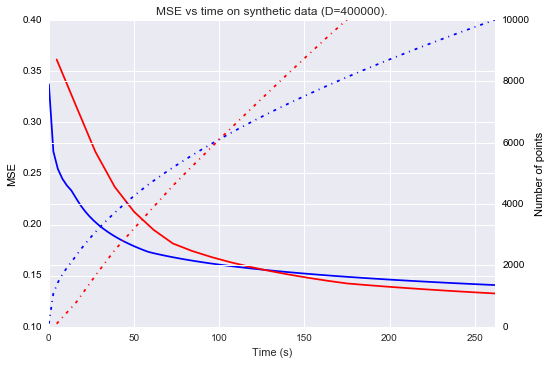

In [121]:
from scipy.interpolate import interp1d

def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

kind = 'linear'
f0 = log_interp1d(ovk_time_t, ovk_err_t, kind=kind)
f1 = log_interp1d(orff_time_t, orff_err_t, kind=kind)
ovk_time_tn = np.linspace(ovk_time_t[0], ovk_time_t[-1], 100)
orff_time_tn = np.linspace(orff_time_t[0], orff_time_t[-1], 100)

pts_ovk_t = np.logspace(2, 5, 10)[:ovk_err_t.shape[0]]
pts_orff_t = np.logspace(2, 5, 10)[:orff_err_t.shape[0]]
f2 = log_interp1d(ovk_time_t, pts_ovk_t, kind=kind)
f3 = log_interp1d(orff_time_t, pts_orff_t, kind=kind)

fig, ax1 = plt.subplots()
ax1.plot(ovk_time_tn, f0(ovk_time_tn), 'b')
ax1.plot(orff_time_tn, f1(orff_time_tn), 'r')
ax1.set_xlabel('Time (s)')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('MSE', color='k')
for tl in ax1.get_yticklabels():
    tl.set_color('k')


ax2 = ax1.twinx()
ax2.plot(ovk_time_tn, f2(ovk_time_tn), 'b-.')
ax2.plot(orff_time_tn, f3(orff_time_tn), 'r-.')
ax2.set_ylabel('Number of points', color='k')
for tl in ax2.get_yticklabels():
    tl.set_color('k')
    
ax2.set_ylim(0, 10000)
ax2.set_xlim(0, 262)
plt.title('MSE vs time on synthetic data (D=400000).')
plt.show()